训练tokenizer的目的是为了压缩文本，模型的上下文长度是有限的，训练时词表会扩大，导致文本内容被压缩

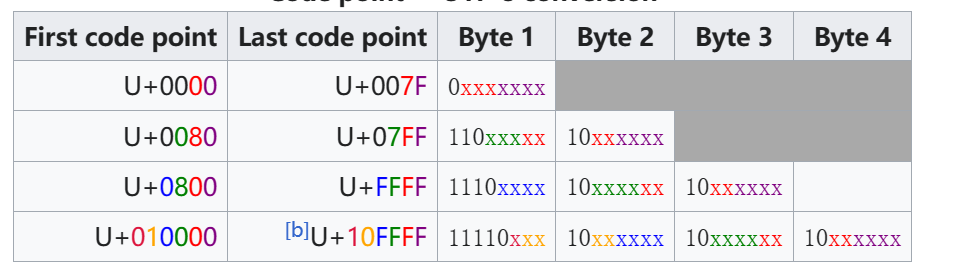

中文用三个字节编码

### 基本BPE实现

In [40]:
with open('天龙八部.txt', 'r',encoding='utf-8') as f:
    text = f.read()
tokens=list(map(int,text.encode('utf-8')))
print(len(tokens))
print(tokens[:100])

3791847
[228, 184, 128, 32, 233, 157, 146, 232, 161, 171, 231, 163, 138, 232, 144, 189, 233, 153, 169, 229, 179, 176, 232, 161, 140, 10, 10, 227, 128, 128, 227, 128, 128, 233, 157, 146, 229, 133, 137, 233, 151, 170, 229, 138, 168, 239, 188, 140, 228, 184, 128, 230, 159, 132, 233, 157, 146, 233, 146, 162, 229, 137, 145, 229, 128, 143, 229, 156, 176, 229, 136, 186, 229, 135, 186, 239, 188, 140, 230, 140, 135, 229, 144, 145, 228, 184, 173, 229, 185, 180, 230, 177, 137, 229, 173, 144, 229, 183, 166, 232]


In [41]:
def get_stats(tokens):  #统计每个字节对出现的次数
    stats = {} #存储每个元素对及其出现的次数
    for token in zip(tokens, tokens[1:]):
        stats[token] = stats.get(token, 0) + 1  #统计每个元素对出现的次数
    return stats

def merge(ids,pair,idx):  #将ids中的pair(0),pair(1)合并为idx
    new_ids=[]
    i=0
    while i<len(ids):
        if ids[i]==pair[0] and i+1<len(ids) and ids[i+1]==pair[1]:
            new_ids.append(idx)
            i+=2
        else:
            new_ids.append(ids[i])
            i+=1
    return new_ids

stats=get_stats(tokens)
print(stats)

{(228, 184): 81807, (184, 128): 18189, (128, 32): 6, (32, 233): 6, (233, 157): 3475, (157, 146): 608, (146, 232): 877, (232, 161): 3412, (161, 171): 238, (171, 231): 1326, (231, 163): 299, (163, 138): 15, (138, 232): 1071, (232, 144): 3037, (144, 189): 613, (189, 233): 792, (233, 153): 2246, (153, 169): 391, (169, 229): 2135, (229, 179): 3460, (179, 176): 3522, (176, 232): 2593, (161, 140): 1568, (140, 10): 3, (10, 10): 98, (10, 227): 11074, (227, 128): 54432, (128, 128): 22906, (128, 227): 11589, (128, 233): 4147, (146, 229): 1738, (229, 133): 13244, (133, 137): 1072, (137, 233): 1522, (233, 151): 5801, (151, 170): 406, (170, 229): 7464, (229, 138): 8536, (138, 168): 1342, (168, 239): 1418, (239, 188): 116325, (188, 140): 88900, (140, 228): 21346, (128, 230): 8788, (230, 159): 925, (159, 132): 178, (132, 233): 1851, (146, 233): 568, (233, 146): 1960, (146, 162): 218, (162, 229): 2249, (229, 137): 4006, (137, 145): 1620, (145, 229): 7745, (229, 128): 2409, (128, 143): 142, (143, 229): 

In [42]:
# 训练分词器

vocab_size=266  #最终要构建的词表大小
num_merges=vocab_size-256  #utf-8只有256个编码序列
ids=list(tokens) #复制tokens

merges={}  #存储每次合并的结果
for i in range(num_merges):
    stats=get_stats(ids)
    pair=max(stats,key=stats.get)
    idx=256+i
    print(f"merging:{pair}=>{idx}")
    ids=merge(ids,pair,idx)
    merges[pair]=idx    

# 最终保留merges，就可以构造出词表

merging:(239, 188)=>256
merging:(256, 140)=>257
merging:(228, 184)=>258
merging:(227, 128)=>259
merging:(226, 128)=>260
merging:(228, 186)=>261
merging:(257, 229)=>262
merging:(259, 130)=>263
merging:(229, 164)=>264
merging:(228, 185)=>265


In [59]:
print('token length:',len(tokens))
print('ids length:',len(ids))
merges  #是一个森林

token length: 3791847
ids length: 3264273


{(239, 188): 256,
 (256, 140): 257,
 (228, 184): 258,
 (227, 128): 259,
 (226, 128): 260,
 (228, 186): 261,
 (257, 229): 262,
 (259, 130): 263,
 (229, 164): 264,
 (228, 185): 265}

In [54]:
#构造词表
vocab={idx:bytes([idx]) for idx in range(256)}
for (p0,p1),idx in merges.items():
    vocab[idx]=vocab[p0]+vocab[p1]

def decode(ids):
    tokens= b''.join([vocab[i] for i in ids])
    text=tokens.decode('utf-8',errors='replace')  #将非法utf—8替换为?
    return text

def encode(text):
    tokens=list(text.encode('utf-8'))
    while len(tokens)>1:
        stats=get_stats(tokens)  #统计每个元素对出现的次数
        
        #merges要从前往后查找，最前面的合并对的值最小
        #min 函数会遍历 stats 字典的每一个键，并将每一个键作为参数 p 传递给 lambda 函数。lambda 函数会对每一个键 p 计算 merges.get(p,float('inf')) 的值，然后 min 函数会返回这些值中最小的那个对应的键。
        pair = min(stats,key=lambda p:merges.get(p,float('inf')))
        if pair not in merges:
            break
        idx=merges[pair]
        tokens=merge(tokens,pair,idx)
        #循环直到没有可以合并的元素对
    return tokens

print(len(vocab))  #与训练时的目标vocab_size相同


266


In [55]:
print(encode('今天天气不错'))
print(list('今天天气不错'.encode('utf-8')))
print(decode(encode('今天天气不错')))
print(decode(list('今天天气不错'.encode('utf-8'))))

[228, 187, 138, 264, 169, 264, 169, 230, 176, 148, 258, 141, 233, 148, 153]
[228, 187, 138, 229, 164, 169, 229, 164, 169, 230, 176, 148, 228, 184, 141, 233, 148, 153]
今天天气不错
今天天气不错


### 改进
以上即实现了最简单的BPE算法，但存在问题，如某些标点的字节编码可能聚合到词中，如dog dog. dog, dog!在词表中可能是不同的词


In [66]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat, "今天天气不错 hello!"))

['今天天气不错', ' hello', '!']
